In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

In [13]:
# Import stuff from pone, which includes the code written for this project
from pone.utils import design_matrix, franke_function, mse
from pone.models import LinearRegression
from pone.resamplers import Bootstrapper

In [3]:
np.random.seed(2024)
bs = Bootstrapper(model=LinearRegression(), degree=20)

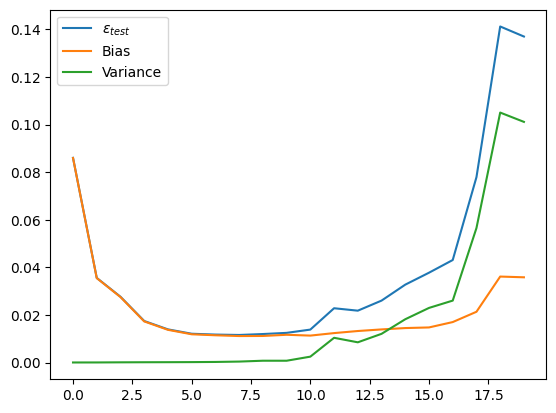

In [4]:
x1_ = np.sort(np.random.uniform(0, 1, 40))
x2_ = np.sort(np.random.uniform(0, 1, 40))
x1, x2 = np.meshgrid(x1_, x2_)
y = franke_function(x1, x2, 1)

p_degrees, error_test, bias, variance = bs.train_loop(x1.ravel(), x2.ravel(), y.ravel())

fig, ax = plt.subplots()
# ax.plot(degrees, error_train, label=r"$\epsilon_{train}$")
ax.plot(p_degrees, error_test, label=r"$\epsilon_{test}$")
ax.plot(p_degrees, bias, label="Bias")
ax.plot(p_degrees, variance, label="Variance")
# ax.set_yscale("log")
ax.legend()
plt.show()

In [5]:
x = np.random.rand(100).reshape(-1, 1)
noise = np.random.normal(0, 0.1, x.shape)
y = np.exp(-x**2) + 1.5 * np.exp(-(x-2)**2) + noise 

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

model = LinearRegression()
model.fit(X_train, y_train)

In [6]:
model.beta

array([[1.42361862]])

In [14]:
x1_ = np.sort(np.random.uniform(0, 1, 40))
x2_ = np.sort(np.random.uniform(0, 1, 40))
x1, x2 = np.meshgrid(x1_, x2_)
y = franke_function(x1, x2, 1)

X = np.column_stack((x1.ravel(), x2.ravel()))
X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(), test_size=0.2)

In [15]:
degree = 5
n_bootstraps = 100

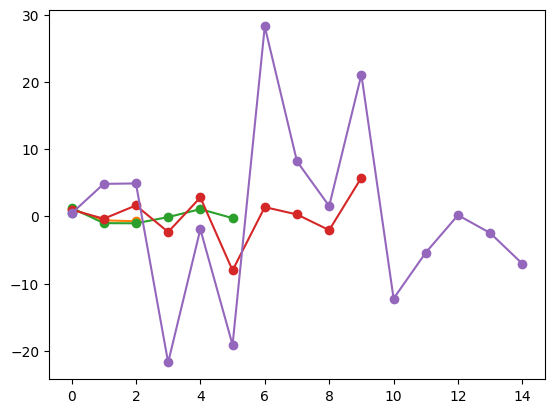

In [21]:
x1_train = X_train[:, 0]
x2_train = X_train[:, 1]

x1_test = X_test[:, 0]
x2_test = X_test[:, 1]

model = LinearRegression()
beta = np.zeros(degree)
error_test = np.zeros(degree)
bias = np.zeros(degree)
variance = np.zeros(degree)

fig, ax = plt.subplots()

for p in range(degree):
    Xtrain = design_matrix([x1_train, x2_train], p)
    Xtest = design_matrix([x1_test, x2_test], p)

    model.fit(Xtrain, y_train)
    y_pred = model.predict(Xtest)

    ax.plot(model.beta, 'o-')

    error_test[p] = mse(y_test, y_pred)
    bias[p] = np.mean((y_test - np.mean(y_pred))**2)
    variance[p] = np.mean(np.var(y_pred))

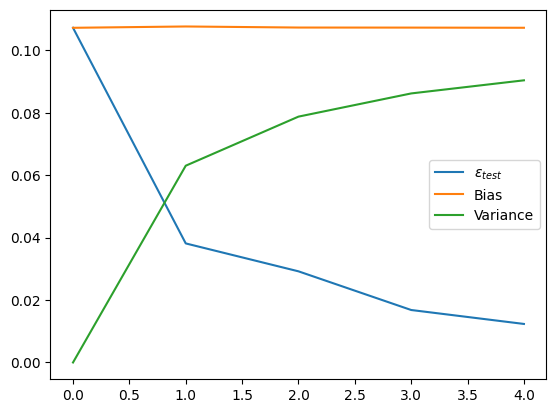

In [20]:
p_degrees = np.arange(degree)

fig, ax = plt.subplots()
# ax.plot(degrees, error_train, label=r"$\epsilon_{train}$")
ax.plot(p_degrees, error_test, label=r"$\epsilon_{test}$")
ax.plot(p_degrees, bias, label="Bias")
ax.plot(p_degrees, variance, label="Variance")
# ax.set_yscale("log")
ax.legend()
plt.show()